# Analyzing the Titanic survivals based on the sociodemographic characteristics

# Import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from scipy.stats import randint
from IPython.utils import io

# Titanic dataset

Titanic dataset is a classic dataset based on the real historical event of the sinking of the RMS Titanic in 1912. The dataset contains information about the passengers who were aboard the Titanic and whether they survived or not.

The primary goal of this analysis was using this dataset to predict the survival of passengers based on various features, and getting insights of how the sociodemographic characteristics are related to the survival chances.

| Feature       | Description                                                              |
|:--------------|:-------------------------------------------------------------------------|
| PassengerId   | Unique identifier for each passenger                                     |
| Survived      | Survival status (0 = No, 1 = Yes)                                        |
| Pclass        | Passenger class (1 = 1st, 2 = 2nd, 3 = 3rd)                              |
| Name          | Name of the passenger                                                    |
| Sex           | Gender of the passenger                                                  |
| Age           | Age of the passenger                                                     |
| SibSp         | Number of siblings or spouses aboard the Titanic                         |
| Parch         | Number of parents or children aboard the Titanic                         |
| Ticket        | Ticket number                                                            |
| Fare          | Fare paid for the ticket                                                 |
| Cabin         | Cabin number                                                             |
| Embarked      | Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)     |


In [ ]:
# Load the Titanic dataset
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
data = pd.read_csv(url)

# Display the first few rows of the dataset
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Data Exploration

 Through exploratory data analysis, we can identify missing values, outliers, and the relationships between features and the target variable (survival). This step is essential for making informed decisions about data preprocessing, feature engineering, and selecting appropriate modeling techniques, ultimately leading to more accurate and insightful predictions.

In [ ]:
data.describe().round(4)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.0000,891.0000,891.0000,714.0000,891.0000,891.0000,891.0000
mean,446.0000,0.3838,2.3086,29.6991,0.5230,0.3816,32.2042
std,257.3538,0.4866,0.8361,14.5265,1.1027,0.8061,49.6934
min,1.0000,0.0000,1.0000,0.4200,0.0000,0.0000,0.0000
25%,223.5000,0.0000,2.0000,20.1250,0.0000,0.0000,7.9104
50%,446.0000,0.0000,3.0000,28.0000,0.0000,0.0000,14.4542
75%,668.5000,1.0000,3.0000,38.0000,1.0000,0.0000,31.0000
max,891.0000,1.0000,3.0000,80.0000,8.0000,6.0000,512.3292


In [ ]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


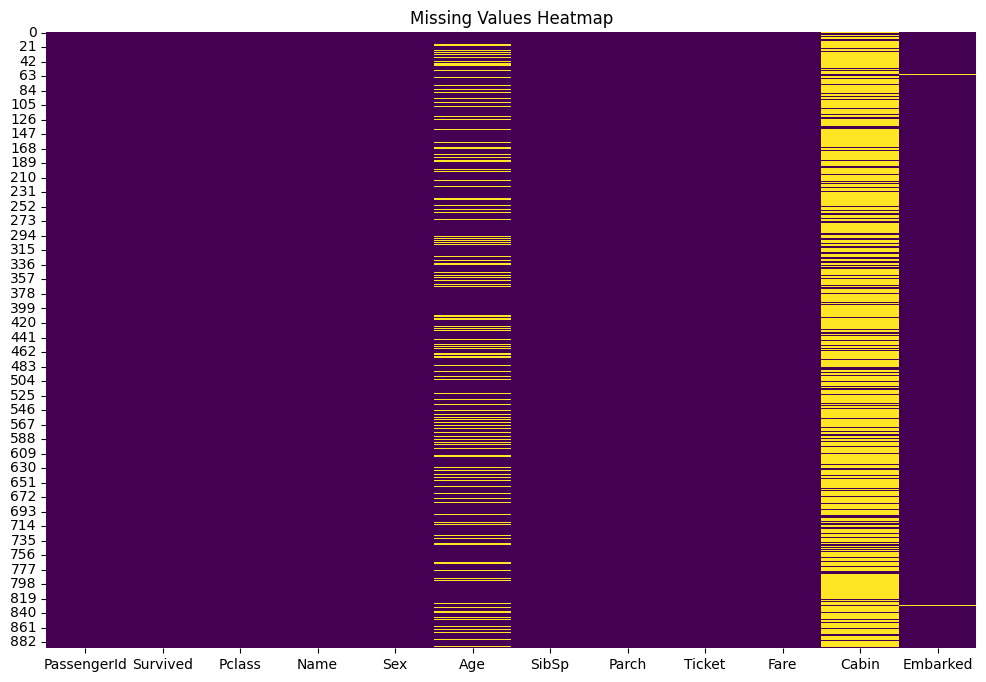

In [ ]:
# Visualize missing values
plt.figure(figsize=(12, 8))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

<Figure size 1400x600 with 0 Axes>

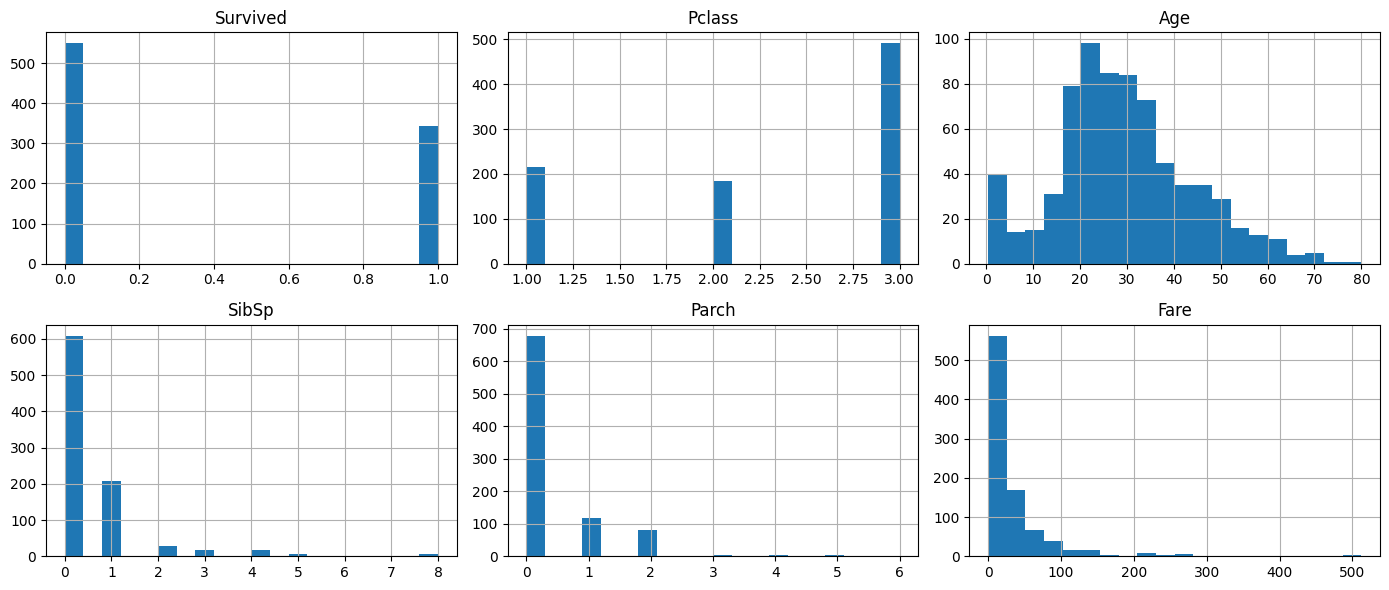

In [ ]:
data_dist = data.drop(['PassengerId'], axis=1, inplace=False)

# Distribution of numerical features
plt.figure(figsize=(14, 6))
data_dist.hist(bins=20, figsize=(14, 6), layout=(2, 3))
plt.tight_layout()
plt.show()

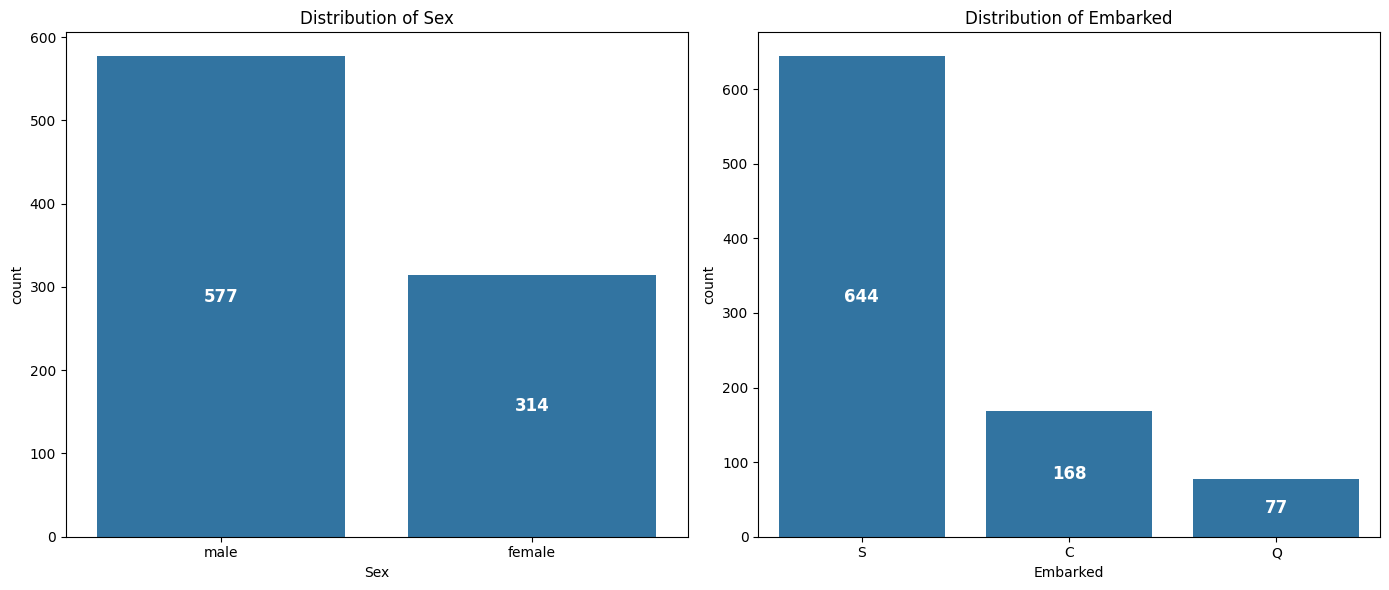

In [ ]:
# Distribution of categorical features with absolute values
plt.figure(figsize=(14, 6))
for i, col in enumerate(['Sex', 'Embarked']):
    plt.subplot(1, 2, i+1)
    ax = sns.countplot(x=data[col])
    plt.title(f'Distribution of {col}')

    # Annotate each bar with the count
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height() / 2),
                 ha='center', va='center',
                 xytext=(0, 0), textcoords='offset points',
                 color='white', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

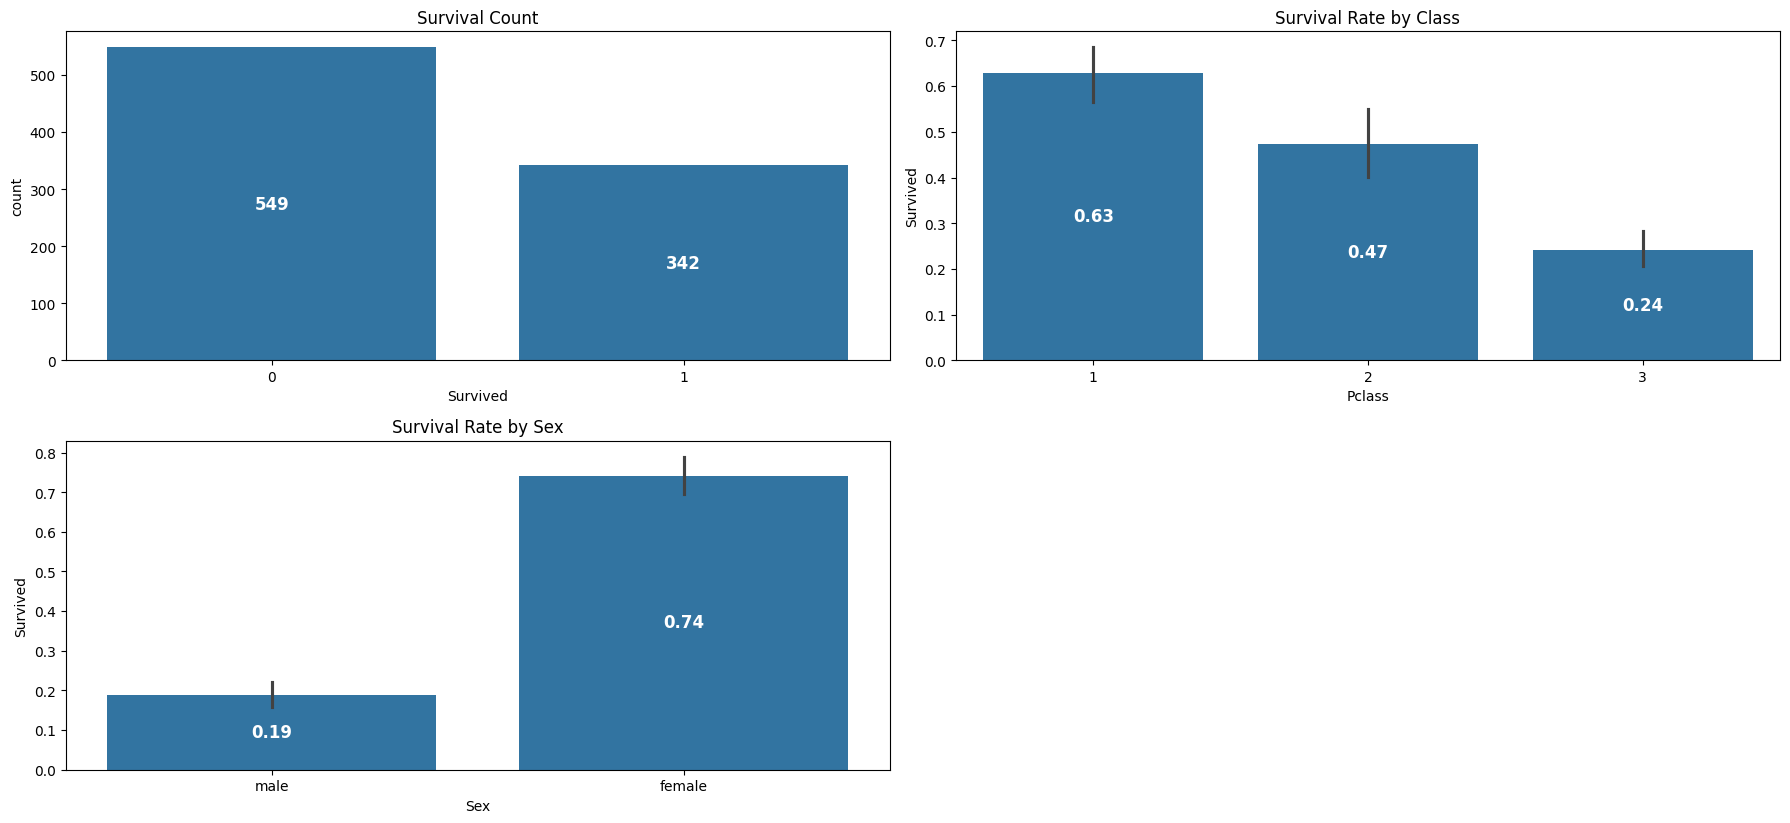

In [ ]:
# Plot the visualizations on the same subplot
plt.figure(figsize=(18, 12))

# Survival count
plt.subplot(3, 2, 1)
ax1 = sns.countplot(x='Survived', data=data)
plt.title('Survival Count')
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_height())}',
                 (p.get_x() + p.get_width() / 2., p.get_height() / 2.),
                 ha='center', va='center',
                 xytext=(0, 0), textcoords='offset points',
                 color='white', fontsize=12, fontweight='bold')

# Survival rate by class
plt.subplot(3, 2, 2)
ax2 = sns.barplot(x='Pclass', y='Survived', data=data)
plt.title('Survival Rate by Class')
for p in ax2.patches:
    height = p.get_height()
    ax2.annotate(f'{height:.2f}',
                 (p.get_x() + p.get_width() / 2., height / 2.),
                 ha='center', va='center',
                 xytext=(0, 0), textcoords='offset points',
                 color='white', fontsize=12, fontweight='bold')

# Survival rate by sex
plt.subplot(3, 2, 3)
ax3 = sns.barplot(x='Sex', y='Survived', data=data)
plt.title('Survival Rate by Sex')
for p in ax3.patches:
    height = p.get_height()
    ax3.annotate(f'{height:.2f}',
                 (p.get_x() + p.get_width() / 2., height / 2.),
                 ha='center', va='center',
                 xytext=(0, 0), textcoords='offset points',
                 color='white', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

**Survival Rate by Class:**

* 1st Class: Passengers in the 1st class had the highest survival rate, with approximately 60-70% of them surviving.
* 2nd Class: Passengers in the 2nd class had a moderate survival rate, with approximately 45-55% of them surviving.
* 3rd Class: Passengers in the 3rd class had the lowest survival rate, with less than 30% of them surviving.

Higher-class passengers had a better chance of survival compared to lower-class passengers. This could be due to factors such as better access to lifeboats and priority given to higher-class passengers during the evacuation process.

**Survival Rate by Sex:**

* Male: The survival rate for male passengers was relatively low, with less than 20% of them surviving.
* Female: The survival rate for female passengers was significantly higher, with approximately 70-80% of them surviving.

Female passengers had a much higher chance of survival compared to male passengers. This aligns with the historical accounts of the Titanic disaster, where the "women and children first" protocol was followed during the evacuation, giving priority to female passengers.

Text(0.5, 1.0, 'Survival Rate by Age')

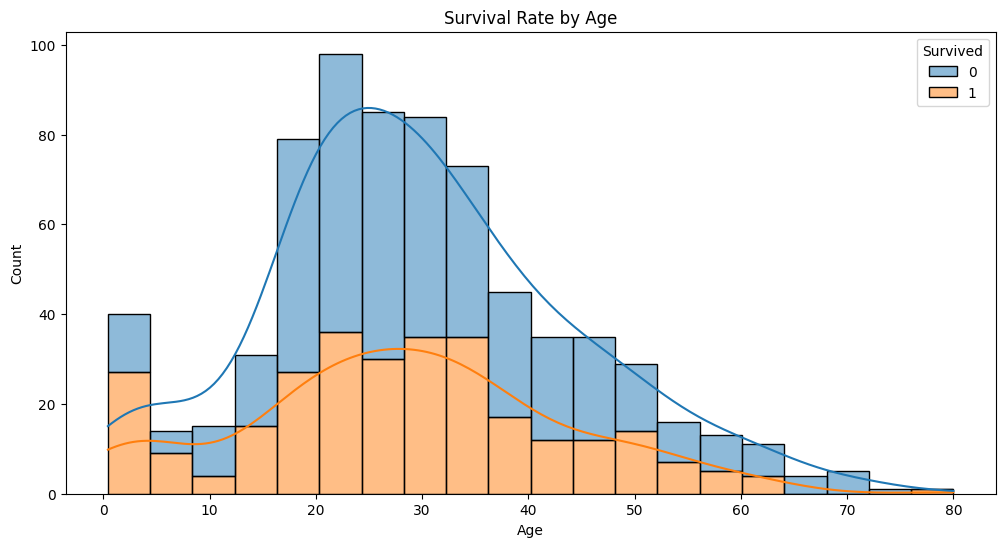

In [ ]:
# Survival rate by age
plt.figure(figsize=(12, 6))
sns.histplot(data=data, x='Age', hue='Survived', multiple='stack', kde=True)
plt.title('Survival Rate by Age')

Age was an important factor in determining survival chances, with very young children having the best chances of survival and the survival rate generally decreasing with age.

* Passengers who were very young (below 10 years) had a higher survival rate compared to other age groups. This could be due to the "women and children first" protocol.
* Passengers in their late teens to early 30s had a lower survival rate. The survival rate for this age group seems to decrease slightly.
* As age increases beyond 30, the survival rate continues to decrease. Older passengers had a lower survival rate.

Text(0.5, 1.0, 'Survival Rate by Fare')

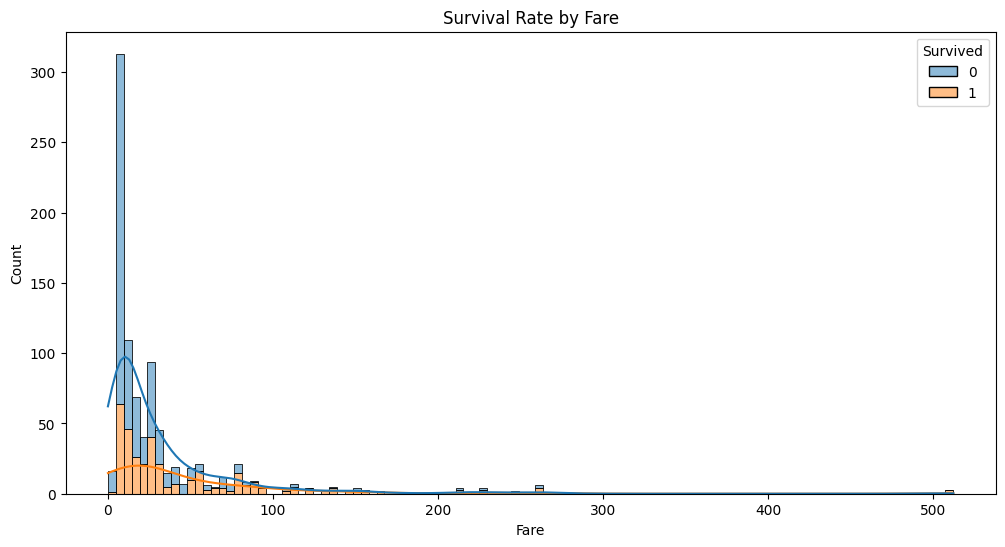

In [ ]:
# Survival rate by fare
plt.figure(figsize=(12, 6))
sns.histplot(data=data, x='Fare', hue='Survived', multiple='stack', kde=True)
plt.title('Survival Rate by Fare')

The fare paid by passengers is positively correlated with survival rates, indicating that passengers who paid higher fares (and thus likely traveled in higher classes) had better survival chances.

* Passengers who paid lower fares (close to zero) had a lower survival rate. This could correlate with passengers in the lower classes.
* There is a noticeable increase in the survival rate for passengers who paid moderate fares (around 20-50). These passengers had a higher likelihood of being in higher classes.
* Passengers who paid very high fares (100 and above) also had higher survival rates. These were likely first-class passengers who had better access to lifeboats.

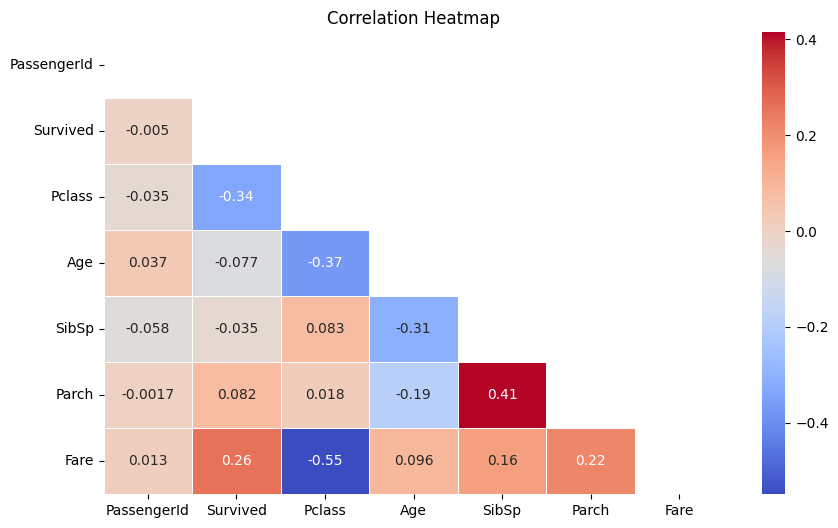

In [ ]:
# Drop non-numeric columns for correlation heatmap
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
corr = numeric_data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Draw the heatmap with the mask
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

The correlation heatmap provides a visual representation of the correlation coefficients between different features in the Titanic dataset. Correlation coefficients range from -1 to 1, where:

**Survived and Pclass**
* The correlation between Survived and Pclass is **-0.34**, indicating a moderate negative correlation. This means that as the passenger class increases (where 3 is the lowest class), the likelihood of survival decreases. Passengers in higher classes had a better chance of survival.
Survived and Fare:

**Survived and Fare**
* The correlation between Survived and Fare is **0.26**, indicating a weak positive correlation. Passengers who paid higher fares had a slightly better chance of survival, which aligns with the observation that wealthier passengers (often in higher classes) had better survival rates.


 # Data Preparation

Data preparation is critical step in the data analysis and machine learning. It involves cleaning and transforming raw data into a suitable format for processing. Effective data preparation enhances the quality and reliability of the data, leading to more accurate and meaningful analysis and predictions.

It usually involves the following:

1. **Handling Missing Values:** Ensures that missing or incomplete data does not bias or distort the analysis and model outcomes.
2. **Encoding Categorical Variables:** Converts categorical data into numerical format, enabling it to be used effectively in algorithms that require numerical input.
3. **Scaling Features:** Normalizes data to ensure that features with different scales do not disproportionately influence the model.
4. **Feature Selection:** Identifies and retains the most relevant features, improving model performance and interpretability.

In [ ]:
# Fill missing values
data['Age'].fillna(data['Age'].median(), inplace=True)
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)
data['Fare'].fillna(data['Fare'].median(), inplace=True)

In [ ]:
# Encode categorical variables
label_encoder = LabelEncoder()
data['Sex'] = label_encoder.fit_transform(data['Sex'])
data['Embarked'] = label_encoder.fit_transform(data['Embarked'])

In [ ]:
# Feature selection
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
X = data[features]
y = data['Survived']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Data Processing

Five predictive models were used on this project, with a Decision Tree as basis and four ensemble tree methods.

1. A **Decision Tree** is a flowchart-like model used for classification and regression. It splits the data into branches based on feature values, making decisions at each node to maximize information gain or minimize impurity. The process continues until each branch ends in a leaf node representing a predicted outcome.

2. A **Random Forest** is an ensemble learning method that combines multiple decision trees to improve predictive accuracy and control overfitting. Each tree is trained on a random subset of the data, and their predictions are averaged (for regression) or taken as the majority vote (for classification) to produce the final prediction.

3. **Gradient Boosting** builds an ensemble of weak learners, typically decision trees, sequentially. Each new tree corrects errors made by the previous trees by focusing on the residuals (errors) of the previous predictions. This iterative approach minimizes the overall prediction error.

4. **XGBoost** (Extreme Gradient Boosting) is an advanced implementation of gradient boosting that optimizes both speed and performance. It uses techniques like regularization, parallel processing, and tree pruning to enhance accuracy and prevent overfitting, making it highly efficient for large-scale data.

5. **LightGBM** (Light Gradient Boosting Machine) is another gradient boosting framework that is designed to be highly efficient and scalable. It uses a novel technique called Gradient-based One-Side Sampling (GOSS) and Exclusive Feature Bundling (EFB) to reduce training time and memory usage while maintaining high accuracy.

Hyperparameter tuning is a crucial step in the machine learning workflow that involves optimizing the parameters that control the learning process of a model. Unlike model parameters, which are learned during training, hyperparameters must be set before training begins. The importance of hyperparameter tuning lies in:

1. Improving Model Performance
2. Preventing Overfitting and Underfitting
3. Enhancing Model Robustness
4. Maximizing Efficiency



In [ ]:
# Define parameter grids for each model
param_grid_decision_tree = {
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20)
}

param_grid_random_forest = {
    'n_estimators': randint(10, 200),
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20)
}

param_grid_gradient_boosting = {
    'n_estimators': randint(10, 200),
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20)
}

param_grid_xgboost = {
    'n_estimators': randint(10, 200),
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': randint(1, 20),
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

param_grid_lightgbm = {
    'n_estimators': randint(10, 200),
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'num_leaves': randint(20, 50),
    'max_depth': randint(-1, 20),
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0]
}

**Randomized Search** was adopted as the hyperparameter tuning technique to optimize the performance of the models. Instead of exhaustively searching through all possible combinations of hyperparameters (as in Grid Search), Randomized Search randomly selects a subset of hyperparameter combinations to evaluate.

In [ ]:
# function to hide output
with io.capture_output() as captured:
  # Initialize models
  decision_tree = DecisionTreeClassifier()
  random_forest = RandomForestClassifier()
  gradient_boosting = GradientBoostingClassifier()
  xgboost = XGBClassifier()
  lightgbm = LGBMClassifier()

  # Initialize RandomizedSearchCV for each model
  random_search_decision_tree = RandomizedSearchCV(decision_tree, param_distributions=param_grid_decision_tree, n_iter=50, cv=5, random_state=42)
  random_search_random_forest = RandomizedSearchCV(random_forest, param_distributions=param_grid_random_forest, n_iter=50, cv=5, random_state=42)
  random_search_gradient_boosting = RandomizedSearchCV(gradient_boosting, param_distributions=param_grid_gradient_boosting, n_iter=50, cv=5, random_state=42)
  random_search_xgboost = RandomizedSearchCV(xgboost, param_distributions=param_grid_xgboost, n_iter=50, cv=5, random_state=42)
  random_search_lightgbm = RandomizedSearchCV(lightgbm, param_distributions=param_grid_lightgbm, n_iter=50, cv=5, random_state=42)

  # Train models
  random_search_decision_tree.fit(X_train, y_train)
  random_search_random_forest.fit(X_train, y_train)
  random_search_gradient_boosting.fit(X_train, y_train)
  random_search_xgboost.fit(X_train, y_train)
  random_search_lightgbm.fit(X_train, y_train)

# Evaluation

Using the test set, which comprises 20% of the total dataset, predictions were made to evaluate the performance of the machine learning models. The following metrics were used for evaluation along with a confusion matrix to highlight the visualize the accuracy.

| **Metric**            | **Description**                                                                                             |
|:-----------------------|:-------------------------------------------------------------------------------------------------------------|
| **Precision**         | The ratio of true positive predictions to the total predicted positives. Indicates how many of the predicted positive cases are actually positive. |
| **Recall**            | The ratio of true positive predictions to the total actual positives. Indicates how many of the actual positive cases are correctly identified.    |
| **F1-Score**          | The harmonic mean of precision and recall. Provides a balance between precision and recall.                                                      |
| **Support**           | The number of actual occurrences of each class in the test set.                                                                                    |
| **Accuracy**          | The ratio of correctly predicted instances to the total instances in the test set. Measures the overall correctness of the model.                 |
| **Macro Average**     | The average of precision, recall, and f1-score calculated for each class independently, without considering class imbalance.                      |
| **Weighted Average**  | The average of precision, recall, and f1-score calculated for each class, weighted by the number of instances of each class.                     |

The confusion matrix is used to visualize the performance of the classification model. It consists of four values:

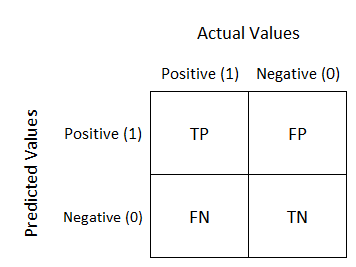

* True Positives (TP): The number of instances correctly predicted as positive.
* True Negatives (TN): The number of instances correctly predicted as negative.
* False Positives (FP): The number of instances incorrectly predicted as positive.
* False Negatives (FN): The number of instances incorrectly predicted as negative.

In [ ]:
# Predict with all models
y_pred_decision_tree = random_search_decision_tree.predict(X_test)
y_pred_random_forest = random_search_random_forest.predict(X_test)
y_pred_gradient_boosting = random_search_gradient_boosting.predict(X_test)
y_pred_xgboost = random_search_xgboost.predict(X_test)
y_pred_lightgbm = random_search_lightgbm.predict(X_test)

In [ ]:
# Evaluate models
def evaluate_model(y_test, y_pred):
    print(75*"_")
    print("Classification Report:\n\n", classification_report(y_test, y_pred, digits=4))
    print(75*"_")

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Create a heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


Decision Tree
___________________________________________________________________________
Classification Report:

               precision    recall  f1-score   support

           0     0.8000    0.8762    0.8364       105
           1     0.7969    0.6892    0.7391        74

    accuracy                         0.7989       179
   macro avg     0.7984    0.7827    0.7877       179
weighted avg     0.7987    0.7989    0.7962       179

___________________________________________________________________________


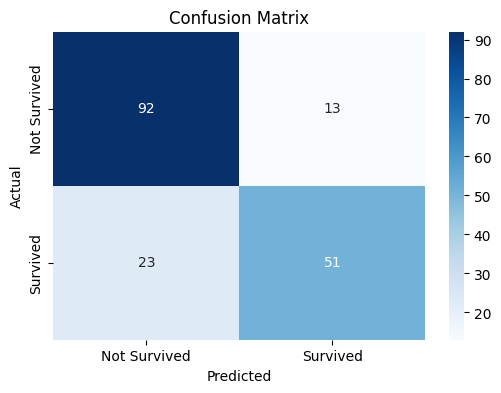

In [ ]:
print("\nDecision Tree")
evaluate_model(y_test, y_pred_decision_tree)


Random Forest
___________________________________________________________________________
Classification Report:

               precision    recall  f1-score   support

           0     0.8034    0.8952    0.8468       105
           1     0.8226    0.6892    0.7500        74

    accuracy                         0.8101       179
   macro avg     0.8130    0.7922    0.7984       179
weighted avg     0.8113    0.8101    0.8068       179

___________________________________________________________________________


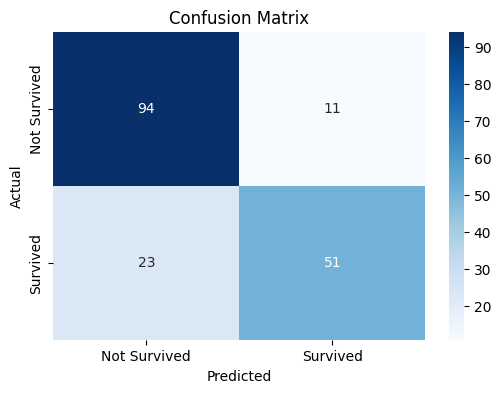

In [ ]:
print("\nRandom Forest")
evaluate_model(y_test, y_pred_random_forest)


Gradient Boosting
___________________________________________________________________________
Classification Report:

               precision    recall  f1-score   support

           0     0.8070    0.8762    0.8402       105
           1     0.8000    0.7027    0.7482        74

    accuracy                         0.8045       179
   macro avg     0.8035    0.7894    0.7942       179
weighted avg     0.8041    0.8045    0.8022       179

___________________________________________________________________________


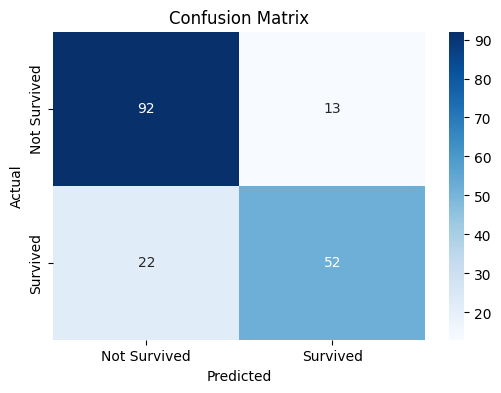

In [ ]:
print("\nGradient Boosting")
evaluate_model(y_test, y_pred_gradient_boosting)


XGBoost
___________________________________________________________________________
Classification Report:

               precision    recall  f1-score   support

           0     0.8158    0.8857    0.8493       105
           1     0.8154    0.7162    0.7626        74

    accuracy                         0.8156       179
   macro avg     0.8156    0.8010    0.8060       179
weighted avg     0.8156    0.8156    0.8135       179

___________________________________________________________________________


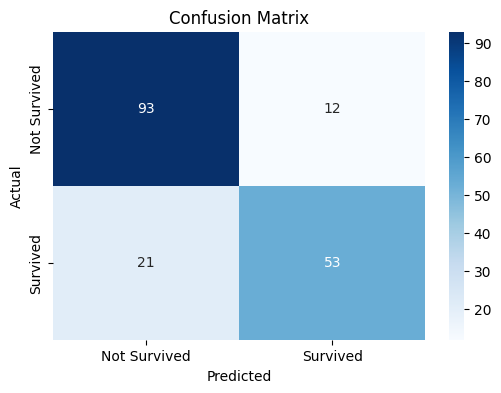

In [ ]:
print("\nXGBoost")
evaluate_model(y_test, y_pred_xgboost)


LightGBM
___________________________________________________________________________
Classification Report:

               precision    recall  f1-score   support

           0     0.8505    0.8667    0.8585       105
           1     0.8056    0.7838    0.7945        74

    accuracy                         0.8324       179
   macro avg     0.8280    0.8252    0.8265       179
weighted avg     0.8319    0.8324    0.8320       179

___________________________________________________________________________


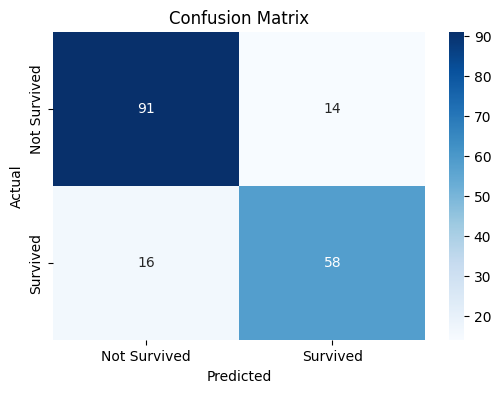

In [ ]:
print("\nLightGBM")
evaluate_model(y_test, y_pred_lightgbm)

In conclusion, LightGBM demonstrates the best performance in this evaluation, followed by XGBoost, Gradient Boosting, Random Forest, and Decision Tree.

**Overall Performance**

Decision Tree:
* Accuracy: 79.89%
* Strengths: Good precision for both classes.
* Weaknesses: Lower recall for survivors, indicating difficulty in correctly identifying all survivors.

Random Forest:

* Accuracy: 80.45%
* Strengths: Improved precision and F1-score compared to the Decision Tree.
* Weaknesses: Similar recall issues for survivors as the Decision Tree.

Gradient Boosting:

* Accuracy: 80.45%
* Strengths: Consistent performance, balanced precision, and recall.
* Weaknesses: Slightly lower recall for survivors compared to non-survivors.

XGBoost:

* Accuracy: 81.56%
* Strengths: Improved recall for survivors, balanced performance across metrics.
* Weaknesses: Slightly lower precision for survivors compared to non-survivors.

LightGBM:

* Accuracy: 83.24%
* Strengths: Best overall performance with highest accuracy, precision, recall, and F1-scores.
* Weaknesses: Slightly lower recall for survivors compared to non-survivors, but still the best among the models evaluated.

**Summary**
* Accuracy: LightGBM achieved the highest accuracy, followed by XGBoost.
* Precision and Recall: LightGBM and XGBoost showed the best balance, with LightGBM excelling in precision and XGBoost in recall for survivors.
* F1-Score: LightGBM had the highest F1-scores, indicating the best balance between precision and recall.

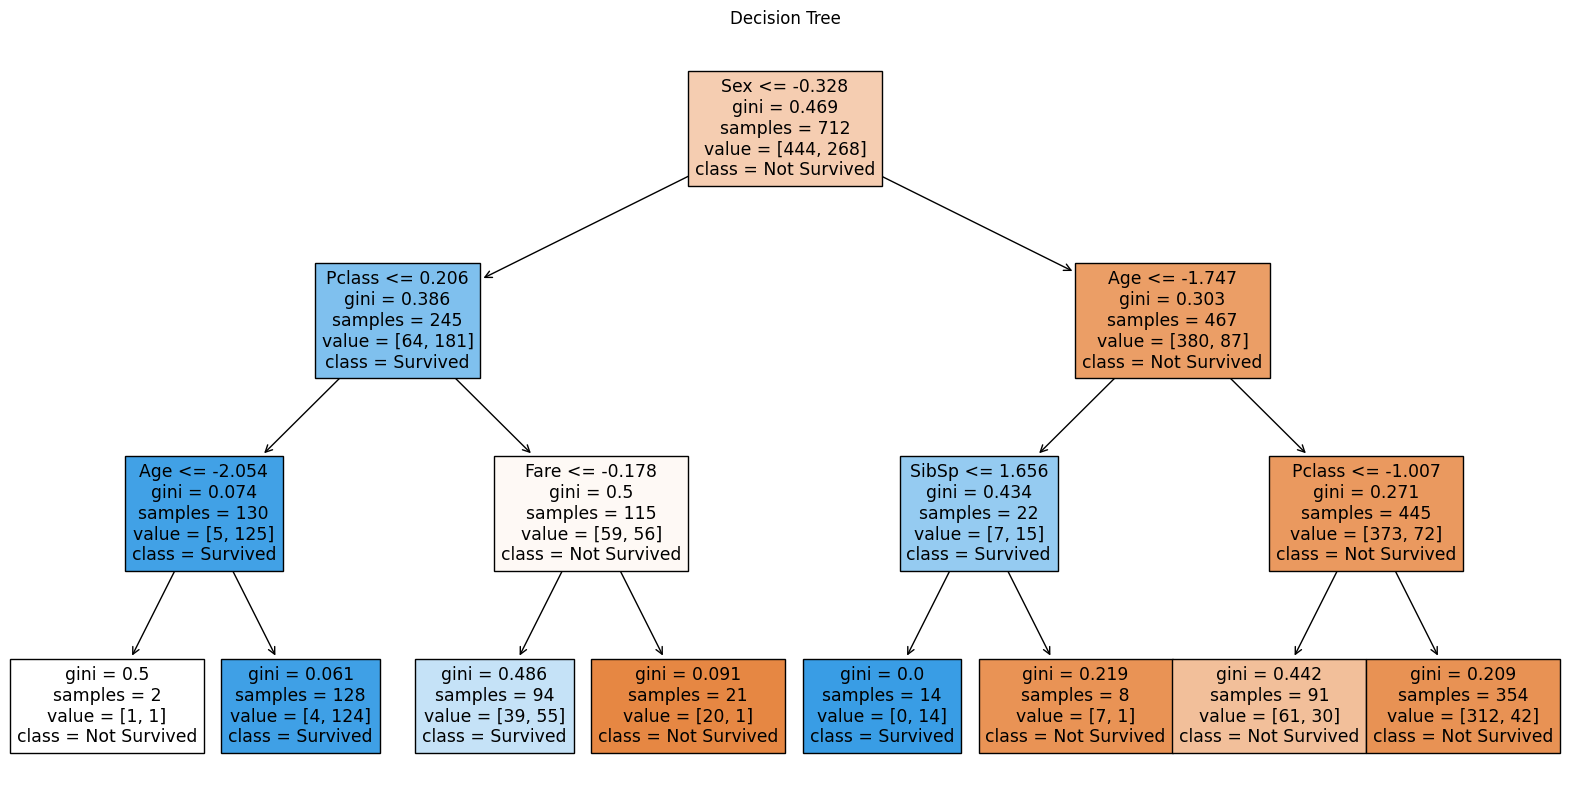

In [ ]:
# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(random_search_decision_tree.best_estimator_, feature_names=features, class_names=['Not Survived', 'Survived'], filled=True)
plt.title("Decision Tree")
plt.show()

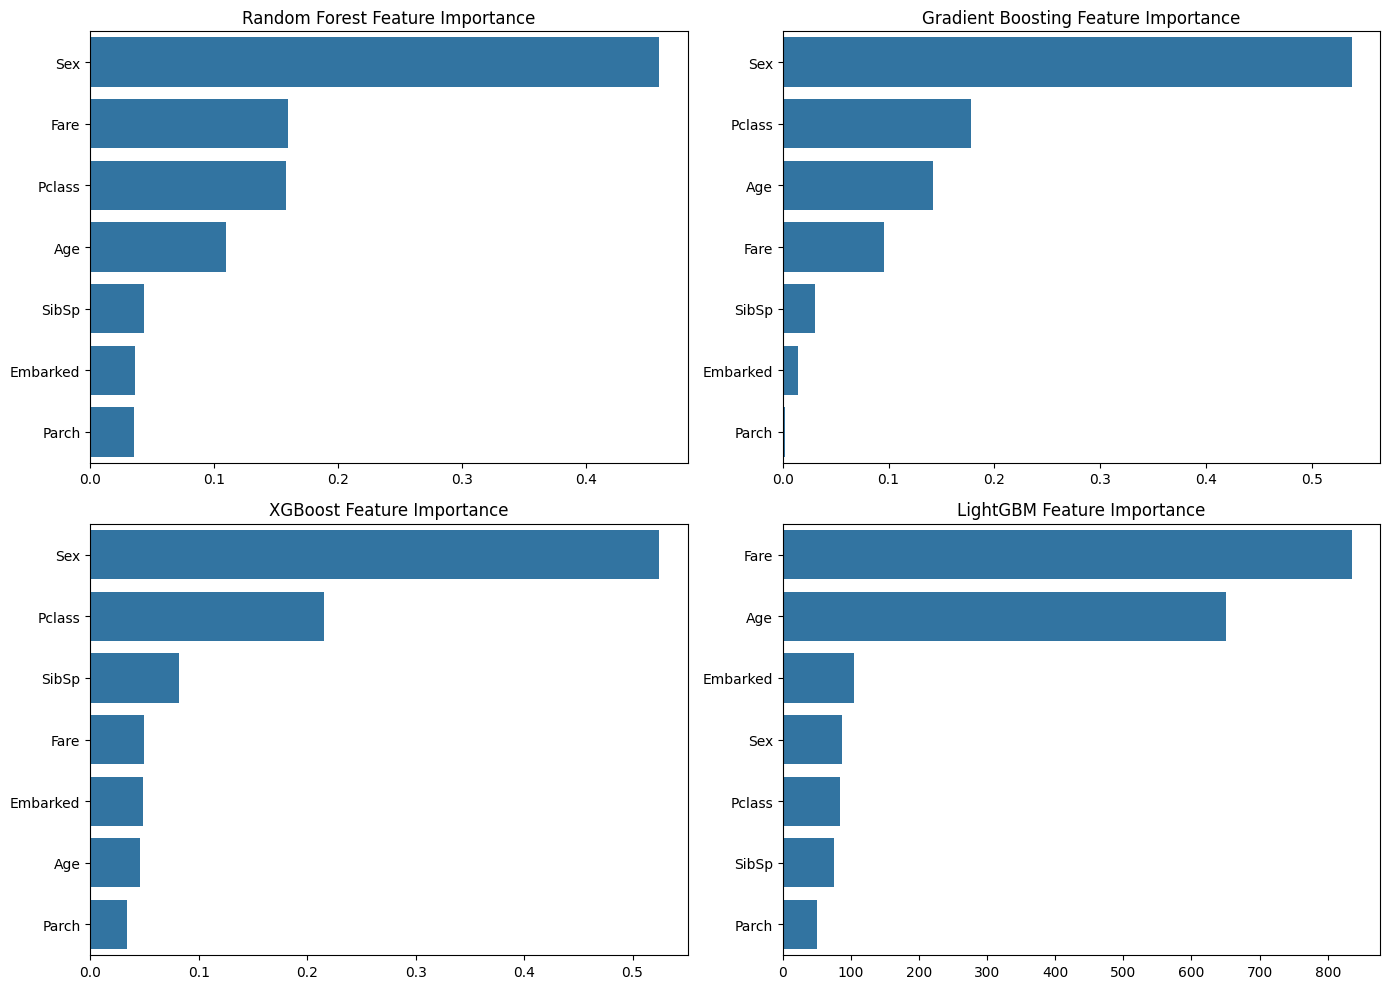

In [ ]:
# Feature importance for Random Forest
rf_feature_importance = pd.Series(random_search_random_forest.best_estimator_.feature_importances_, index=features).sort_values(ascending=False)

# Feature importance for Gradient Boosting
gb_feature_importance = pd.Series(random_search_gradient_boosting.best_estimator_.feature_importances_, index=features).sort_values(ascending=False)

# Feature importance for XGBoost
xgb_feature_importance = pd.Series(random_search_xgboost.best_estimator_.feature_importances_, index=features).sort_values(ascending=False)

# Feature importance for LightGBM
lgbm_feature_importance = pd.Series(random_search_lightgbm.best_estimator_.feature_importances_, index=features).sort_values(ascending=False)

# Plot feature importance
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
sns.barplot(x=rf_feature_importance, y=rf_feature_importance.index)
plt.title('Random Forest Feature Importance')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 2)
sns.barplot(x=gb_feature_importance, y=gb_feature_importance.index)
plt.title('Gradient Boosting Feature Importance')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 3)
sns.barplot(x=xgb_feature_importance, y=xgb_feature_importance.index)
plt.title('XGBoost Feature Importance')
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 2, 4)
sns.barplot(x=lgbm_feature_importance, y=lgbm_feature_importance.index)
plt.title('LightGBM Feature Importance')
plt.xlabel('')
plt.ylabel('')

plt.tight_layout()
plt.show()

**Gender (Sex):**

* Across all models except LightGBM, gender is the most significant predictor of survival, highlighting the social practice of prioritizing women during the Titanic disaster.

**Socioeconomic Status (Fare and Pclass):**

* Fare and Pclass are consistently important features, indicating that passengers in higher socioeconomic classes had better survival rates. This underscores the social disparities and privileges that influenced survival chances.

**Age:**

* Age is an important feature across all models, suggesting that younger passengers, particularly children, had better survival rates. This reflects the social priority given to saving children.

**Family Connections (SibSp and Parch):**

* The presence of family members aboard (SibSp and Parch) had varying importance, with XGBoost showing a higher importance for SibSp. This indicates that family connections might have influenced survival, possibly through mutual assistance during the evacuation.

**Embarked:**

* The port of embarkation (Embarked) is relatively more important in LightGBM, suggesting that where passengers boarded could have influenced their survival chances. This could be due to differences in the demographics and socioeconomic status of passengers boarding at different ports.

The feature importance analysis highlights the strong influence of social characteristics such as gender, socioeconomic status, and age on survival during the Titanic disaster. The consistent importance of these features across different models underscores the significant impact of social norms and inequalities on the survival outcomes. Understanding these factors not only helps in building predictive models but also provides historical insights into the social dynamics of the time.